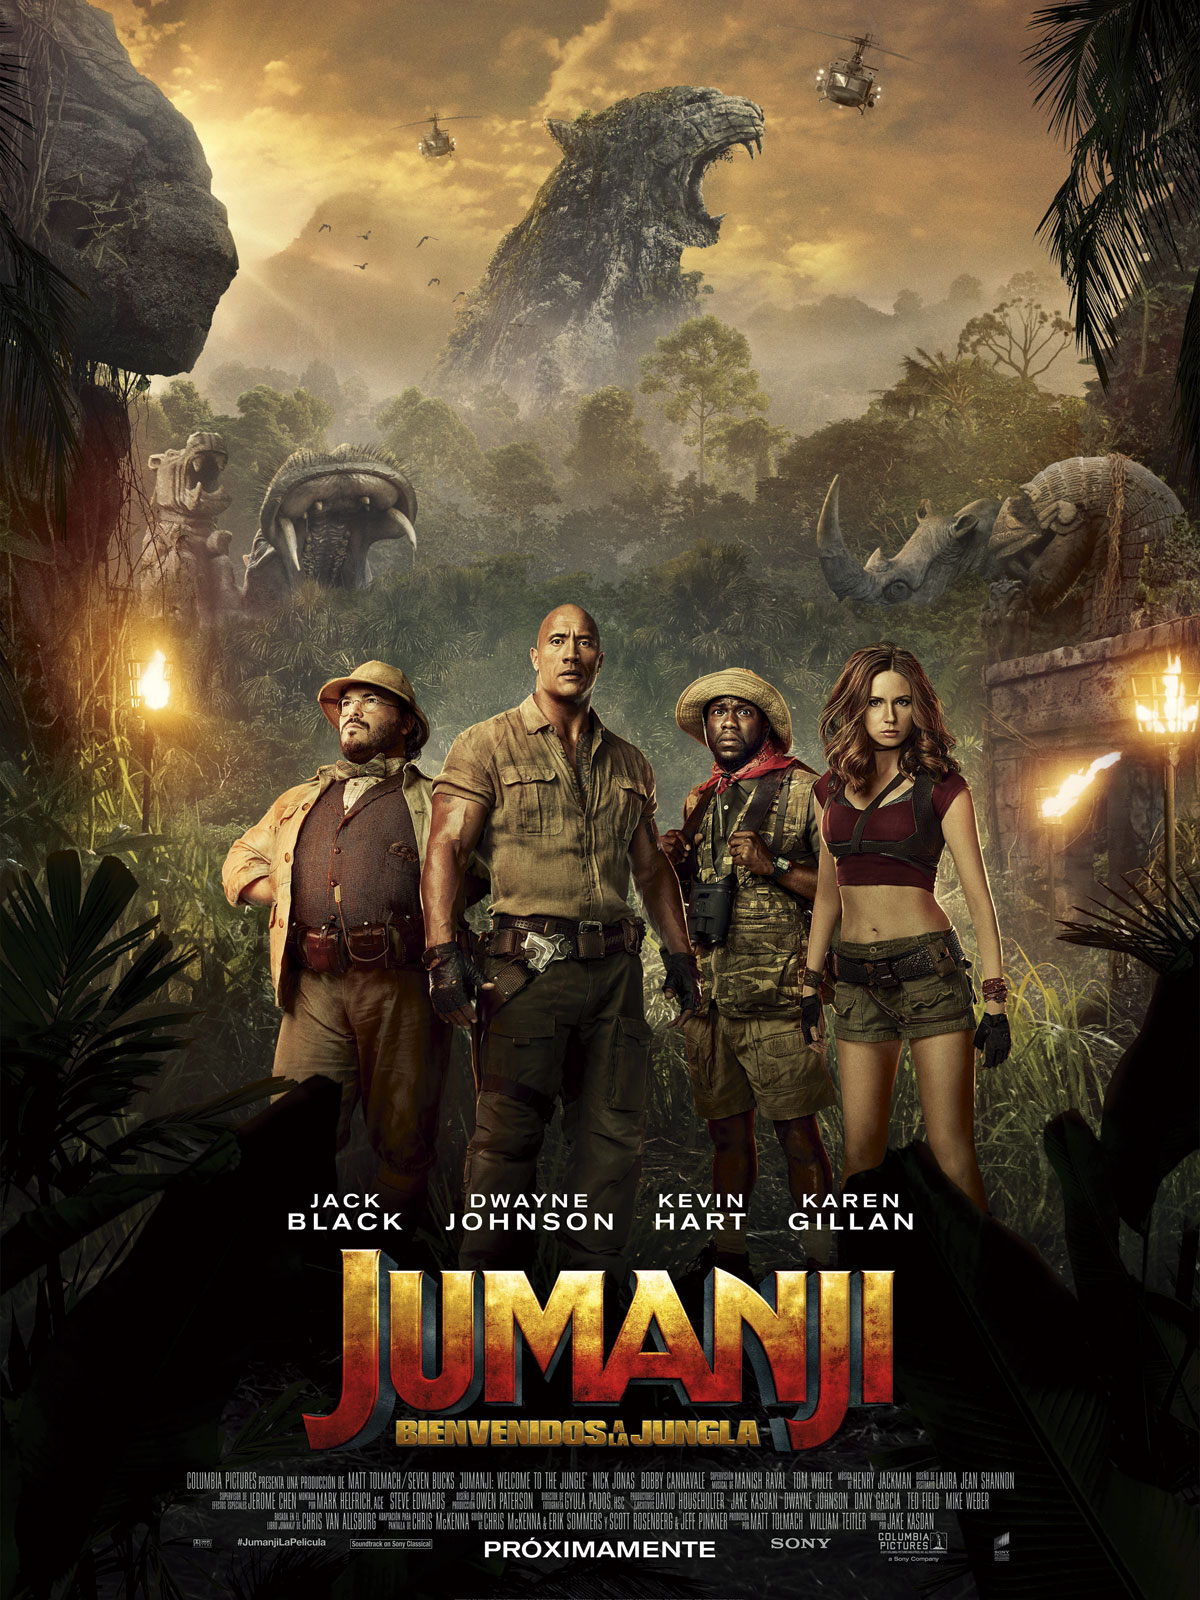

# Ejercicio Jumanji - Bienvenidos a la jungla

Wellcome to Jumanji dear adventurers. Unfortunately not everything are good news, some players have been playing to the game and, as a result of they dumb plays, a stampede of cats and dogs is now running in the real world.

As a fellow explorer I am sure that you understand the urgency of the situation. To solve it, we need to create a computer vision algorithm using CNNs to detect the cats and the dogs.

In order to do so we require the following steps:

- Create an image preprocessing pipeline to treat the images that we are providing. Perform data augmentation over the dataset, at least rotations.

- Test several architechtures (at least 3) and evaluate their performance over the dataset.

- Visualize the feature maps of some of the early and late layers of the models developed. ¿Is there any feature which could be explained through them?

- Finally select the model which performs the best over the whole dataset and explain why.

Fellow adventurer, thanks for your time, Jumanji will not forget your efforts.

In [1]:
import random 
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter, ImageOps, ImageEnhance
import random
import os
import tensorflow.keras as keras
from torch.utils.data import random_split
from glob import glob
from sklearn.model_selection import train_test_split
import shutil
from keras.preprocessing.image import array_to_img, img_to_array, load_img,image_dataset_from_directory
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import zipfile
import shutil
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

from keras.models import Sequential, load_model, Model
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import optimizers
from keras.regularizers import l1, l2

%matplotlib inline
import glob
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import imageio as im
from keras import models
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

1.- Preprocessing

In [2]:
# Funciones data augmentation

def data_aug(entry, i): # i = [ (0:rotation) , (1:blur) , (2:grises) , (3:bajo brillo) ]
    if i==0:
        return entry.rotate(random.randint(-45, 45))
    if i==1:
        return entry.filter(ImageFilter.BLUR)
    if i==2:
        #return ImageOps.grayscale(entry)
        return entry
    if i==3:
        return ImageEnhance.Brightness(entry).enhance(0.4)

In [3]:
%%capture
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /content/cats_and_dogs_filtered.zip
!unzip cats_and_dogs_filtered.zip

In [4]:
base_dir = '/content/cats_and_dogs_filtered/'

#directorios con las imágenes de train
train_cats_dir = os.path.join(base_dir, 'train','cats')
train_dogs_dir = os.path.join(base_dir, 'train','dogs')

#directorios con las imágenes de validation
validation_cats_dir = os.path.join(base_dir, 'validation', 'cats')
validation_dogs_dir = os.path.join(base_dir, 'validation', 'dogs')

In [5]:
#Creamos nuevas carpetas para cats
test_cats_dir = '/content/cats_and_dogs_filtered/test/cats'
os.makedirs(test_cats_dir, exist_ok=True)

#Creamos nuevas carpetas para dogs
test_dogs_dir = '/content/cats_and_dogs_filtered/test/dogs'
os.makedirs(test_dogs_dir, exist_ok=True)

In [6]:
# Movemos 250 imágenes de gatos de validation a la carpeta test
for fname in random.sample(os.listdir('cats_and_dogs_filtered/validation/cats'), 250):
  shutil.move(f"cats_and_dogs_filtered/validation/cats/{fname}", f"cats_and_dogs_filtered/test/cats/{fname}") 

# Movemos 250 imágenes de perros de validation a la carpeta test
for fname in random.sample(os.listdir('cats_and_dogs_filtered/validation/dogs'), 250):
  shutil.move(f"cats_and_dogs_filtered/validation/dogs/{fname}", f"cats_and_dogs_filtered/test/dogs/{fname}") 

In [7]:
#Copiamos la carpeta validation para usar data augmentation en una de ellas
  
src_path = 'cats_and_dogs_filtered/validation' 
dest_path = 'cats_and_dogs_filtered/validation_DA'
destination = shutil.copytree(src_path, dest_path)

validation_DA_cats_dir = os.path.join(base_dir, 'validation_DA','cats')
validation_DA_dogs_dir = os.path.join(base_dir, 'validation_DA','dogs')


In [8]:
print('Total train images - cats:', len(os.listdir(train_cats_dir ) ))
print('Total train images - dogs:', len(os.listdir(train_dogs_dir ) ))

print('Total test images - cats:', len(os.listdir(test_dogs_dir) ))
print('Total test images - dogs:', len(os.listdir(test_cats_dir) ))

print('Total validation images - cats:', len(os.listdir( validation_cats_dir ) ))
print('Total validation images - dogs:', len(os.listdir( validation_dogs_dir ) ))

print('Total validation_DA images - cats:', len(os.listdir(validation_DA_cats_dir) ))
print('Total validation_DA images - dogs:', len(os.listdir(validation_DA_dogs_dir) ))

Total train images - cats: 1000
Total train images - dogs: 1000
Total test images - cats: 250
Total test images - dogs: 250
Total validation images - cats: 250
Total validation images - dogs: 250
Total validation_DA images - cats: 250
Total validation_DA images - dogs: 250


In [9]:
# Selección aleatoria de 15% (máximo total posible 60%) de muestras del total para cada tipo de data augmentation,
# por separado, así algunas se combinarán entre ellas.

n = 15  # % de muestras modificadas

for dir in (train_cats_dir, train_dogs_dir, validation_DA_cats_dir, validation_DA_dogs_dir):
  for i in range(0,4):  # i = [ (0:rotation) , (1:blur) , (2:grises) , (3:bajo brillo) ]
      #random.seed(123)
      randomlist = random.sample(os.listdir(dir), (n*len(os.listdir(dir)))//100 )
      for q in randomlist:
          img = Image.open(dir + '/' + q)
          img = data_aug(img, i)
          img = img.save(dir + '/' + q)

In [10]:
image_size = (180, 180)
batch_size = 32

train_ds = image_dataset_from_directory(
    "cats_and_dogs_filtered/train/",
    image_size=image_size,
    batch_size=batch_size,
    crop_to_aspect_ratio = True,
    label_mode='categorical'
)

test_ds = image_dataset_from_directory(
    "cats_and_dogs_filtered/test/",
    image_size=image_size,
    batch_size=batch_size,
    crop_to_aspect_ratio = True,
    label_mode='categorical'
)

validation_ds = image_dataset_from_directory(
    "cats_and_dogs_filtered/validation/",
    image_size=image_size,
    batch_size=batch_size,
    crop_to_aspect_ratio = True,
    label_mode='categorical'
)

validation_DA_ds = image_dataset_from_directory(
    "cats_and_dogs_filtered/validation_DA/",
    image_size=image_size, 
    batch_size=batch_size,
    crop_to_aspect_ratio = True,
    label_mode='categorical'
)

Found 2000 files belonging to 2 classes.
Found 500 files belonging to 2 classes.
Found 500 files belonging to 2 classes.
Found 500 files belonging to 2 classes.


In [11]:
def show_images_df(class_names,train_ds,range_img):
  plt.figure(figsize=(35,35))

  for images, labels in train_ds.take(1):
    for i in range(range_img):
      #print(i,images)
      ax = plt.subplot(4, 4, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      #plt.title(class_names[labels[i]])
      plt.axis("off")

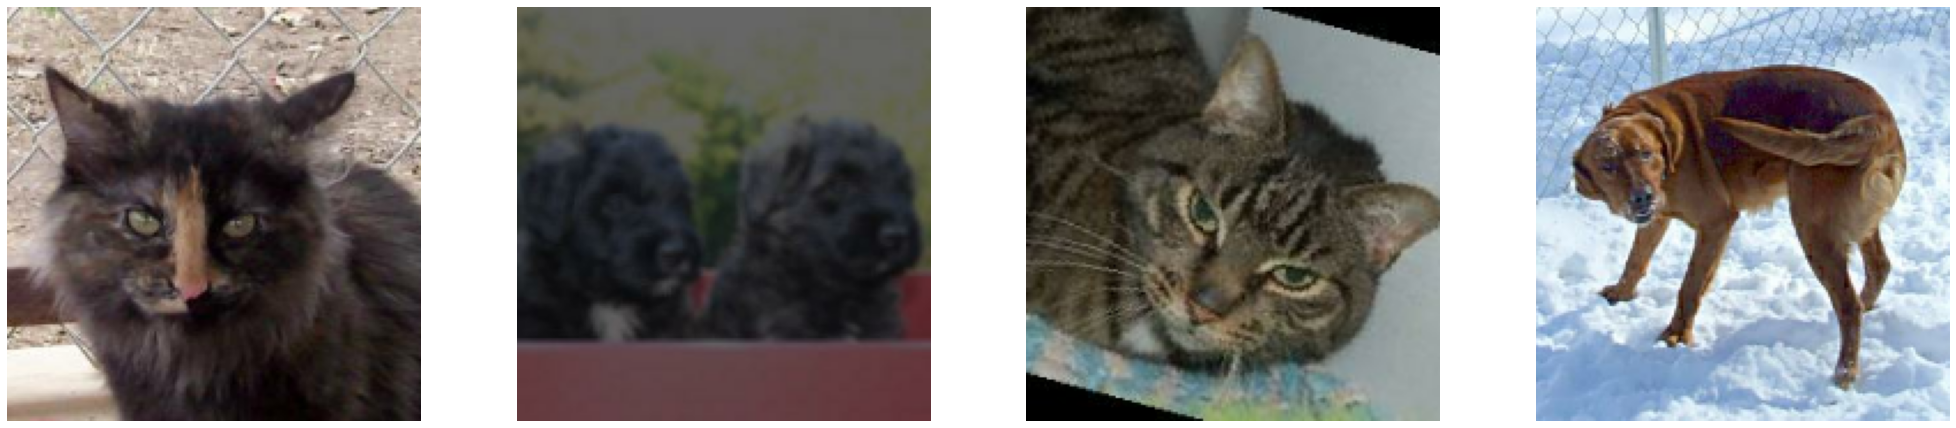

In [12]:
show_images_df(train_ds.class_names,train_ds,4)

In [13]:
image_path= 'cats_and_dogs_filtered/train/cats/cat.11.jpg'
img = load_img(image_path, target_size=(180, 180))

In [14]:
#Visualizamos una de las primeras capas
#nlayer = 3

def generate_feature_map(img, nlayer,model):
  intermediate_layer_model = Model(inputs=model.input, outputs=model.layers[nlayer].output)

  aux = np.expand_dims(img, axis=0)
  layer_out = intermediate_layer_model.predict(aux)

  plt.figure(figsize=(3,3))
  plt.imshow(img, cmap='gray')
  plt.title('input image', size=12)
  plt.xticks(())
  plt.yticks(())
  plt.show()

  print("Salidas capa "+intermediate_layer_model.layers[-1].name, layer_out.shape)

  noutputs = layer_out.shape[-1]
  ncols = 4
  nrows = int(np.ceil(noutputs / ncols))

  ma = abs(layer_out).max()

  plt.subplots(nrows,ncols,figsize = (12, 3*nrows))

  for i in range(noutputs):
      plt.subplot(nrows,ncols,i+1)
      plt.imshow(layer_out[0,:,:,i], cmap='viridis')
      plt.xticks(())
      plt.yticks(())
      plt.title('Salida filtro %d' % i, fontsize=10)

## MODEL 1


In [ ]:
model_1 = keras.Sequential([
    layers.Input((180, 180, 3)),
    layers.Rescaling(scale=1./255), # rescale between 0 and 1
    
    layers.Conv2D(32, 5, activation="relu"),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),  
    
    layers.Conv2D(64, 3, activation="relu"),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),  
    
    layers.Conv2D(128, 3, activation="relu"),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),  
    
    layers.Conv2D(256, 3, activation="relu"),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),  
    
    layers.Flatten(),
    
    layers.Dense(256, activation="relu"),
    layers.BatchNormalization(), 
    layers.Dropout(0.4),
    
    layers.Dense(128, activation="relu"),
    layers.BatchNormalization(), 
    layers.Dropout(0.3),
    
    layers.Dense(64, activation="relu"),
    layers.BatchNormalization(), 
  
    layers.Dense(2, activation="sigmoid") # sigmoid for binary classification   
])

In [ ]:
model_1.compile(
    optimizer = keras.optimizers.Adam(learning_rate=0.01),
    loss='categorical_crossentropy',
    metrics=["accuracy"]
)

In [ ]:
# Add callbacks to minimize validation loss and maximize validation accuracy

callbacks = [
 	EarlyStopping(patience=15, monitor='val_loss', restore_best_weights=True),

	ReduceLROnPlateau(monitor='val_loss', min_lr=1e-7, patience=5, mode='min', verbose=1, factor=0.5),

	ModelCheckpoint(monitor='val_loss', filepath='./best_model.h5', save_best_only=True)
]

In [ ]:
history_1 = model_1.fit(train_ds, epochs=2, callbacks=callbacks, validation_data=validation_ds)

Epoch 1/2
63/63 [==============================] - 16s 86ms/step - loss: 0.7895 - accuracy: 0.5245 - val_loss: 3.6744 - val_accuracy: 0.4960 - lr: 0.0100
Epoch 2/2
63/63 [==============================] - 5s 78ms/step - loss: 0.6840 - accuracy: 0.5645 - val_loss: 0.8079 - val_accuracy: 0.5000 - lr: 0.0100


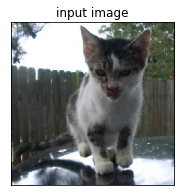

Salidas capa batch_normalization (1, 88, 88, 32)


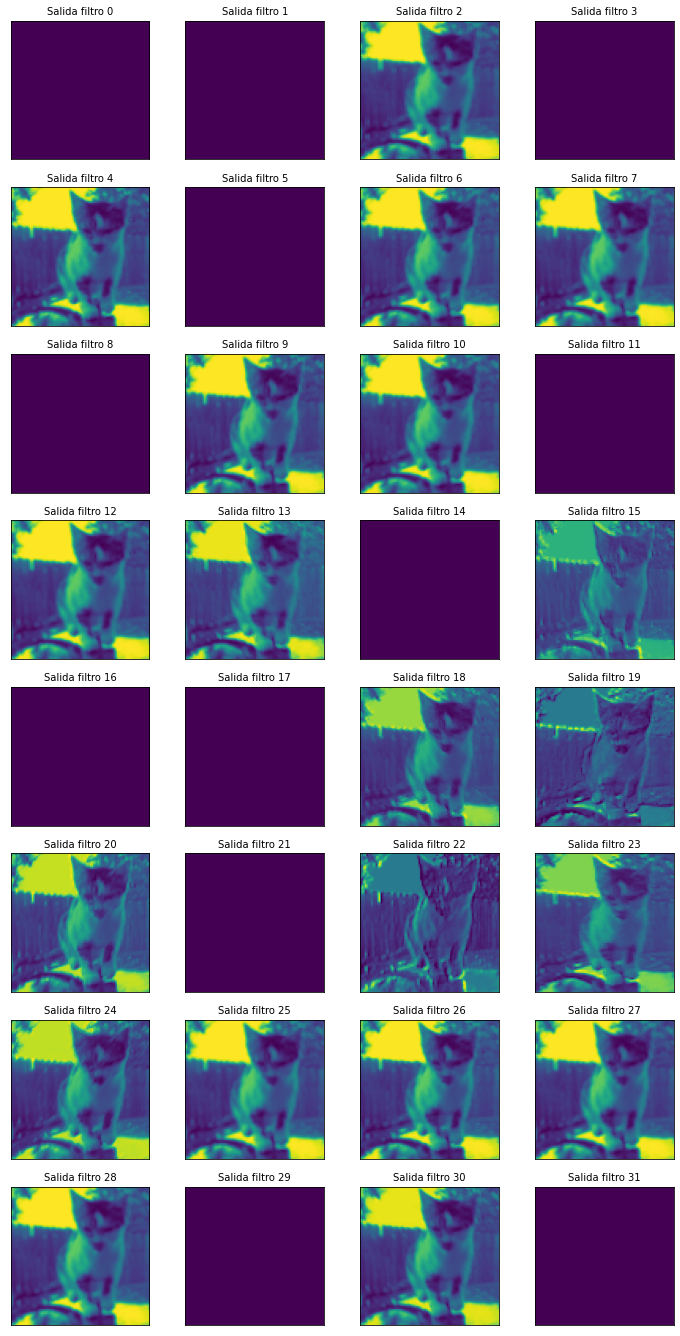

In [ ]:
generate_feature_map(img,3,model_1)

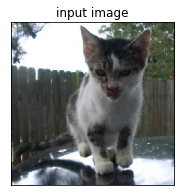

Salidas capa max_pooling2d_3 (1, 9, 9, 256)


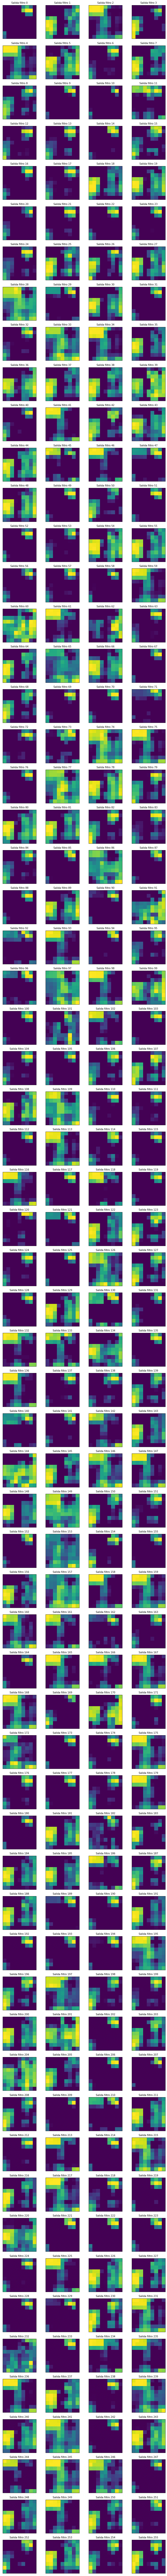

In [ ]:
generate_feature_map(img,11,model_1)

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
validation_datagen = ImageDataGenerator(rescale = 1./255)
validation_DA_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('cats_and_dogs_filtered/train/', target_size = (180, 180),batch_size = 32,class_mode = 'categorical')
test_set = test_datagen.flow_from_directory('cats_and_dogs_filtered/test/', target_size = (180, 180), batch_size = 32, class_mode = 'categorical')
validation_set = validation_datagen.flow_from_directory('cats_and_dogs_filtered/validation/', target_size = (180, 180), batch_size = 32, class_mode = 'categorical')
validation_DA_set = validation_DA_datagen.flow_from_directory('cats_and_dogs_filtered/validation_DA/', target_size = (180, 180), batch_size = 32, class_mode = 'categorical')


Found 2000 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [ ]:
classifier = Sequential()

classifier.add(Conv2D(32, (3, 3), padding='same', input_shape = (180, 180, 3), activation = 'relu'))
classifier.add(Conv2D(32, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Dropout(0.5)) # antes era 0.25
# Adding a second convolutional layer
classifier.add(Conv2D(64, (3, 3), padding='same', activation = 'relu'))
classifier.add(Conv2D(64, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Dropout(0.5)) # antes era 0.25
# Adding a third convolutional layer
classifier.add(Conv2D(128, (3, 3), padding='same', activation = 'relu'))
classifier.add(Conv2D(128, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Dropout(0.5)) # antes era 0.25
# Step 3 - Flattening
classifier.add(Flatten())
# Step 4 - Full connection
classifier.add(Dense(units = 128, activation = 'relu'))
classifier.add(Dropout(0.4)) 
classifier.add(Dense(units = 64, activation = 'relu'))
classifier.add(Dropout(0.3)) 
classifier.add(Dense(units = 2, activation = 'softmax'))

classifier.compile(optimizer = keras.optimizers.Adam(learning_rate=0.01),loss='categorical_crossentropy',metrics=["accuracy"])

In [ ]:
history = classifier.fit(training_set,callbacks=callbacks,epochs = 5,validation_data = validation_set)

Epoch 1/5
63/63 [==============================] - 11s 157ms/step - loss: 30.3810 - accuracy: 0.5035 - val_loss: 0.6944 - val_accuracy: 0.5000 - lr: 0.0100
Epoch 2/5
63/63 [==============================] - 9s 145ms/step - loss: 0.6947 - accuracy: 0.4885 - val_loss: 0.6933 - val_accuracy: 0.5000 - lr: 0.0100
Epoch 3/5
63/63 [==============================] - 9s 144ms/step - loss: 0.6938 - accuracy: 0.4955 - val_loss: 0.6932 - val_accuracy: 0.5000 - lr: 0.0100
Epoch 4/5
63/63 [==============================] - 9s 141ms/step - loss: 0.6943 - accuracy: 0.4815 - val_loss: 0.6933 - val_accuracy: 0.5000 - lr: 0.0100
Epoch 5/5
63/63 [==============================] - 9s 141ms/step - loss: 0.6933 - accuracy: 0.4965 - val_loss: 0.6932 - val_accuracy: 0.5000 - lr: 0.0100


In [ ]:
#classifier = model_1

In [ ]:
#history = classifier.fit(training_set,callbacks=callbacks,epochs = 5,validation_data = validation_set)

In [ ]:
classifier.save('shapes_cnn.h5')

In [ ]:
print(history.history)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc) + 1)

{'loss': [30.381027221679688, 0.6947410106658936, 0.6938154697418213, 0.6943379640579224, 0.693328857421875], 'accuracy': [0.5034999847412109, 0.4884999990463257, 0.49549999833106995, 0.4814999997615814, 0.4964999854564667], 'val_loss': [0.6944195628166199, 0.6933361887931824, 0.6931734085083008, 0.6932671666145325, 0.6932024955749512], 'val_accuracy': [0.5, 0.5, 0.5, 0.5, 0.5], 'lr': [0.01, 0.01, 0.01, 0.01, 0.01]}


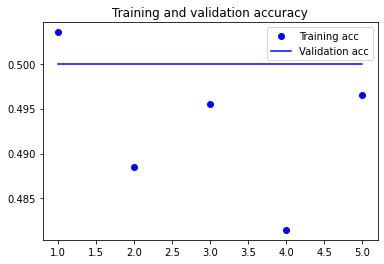

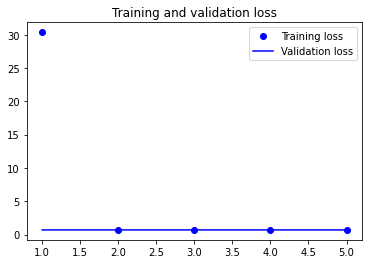

In [ ]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


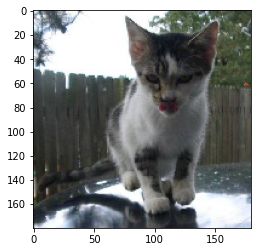

(1, 180, 180, 3)


In [ ]:
img_path= 'cats_and_dogs_filtered/train/cats/cat.11.jpg'
img = image.load_img(img_path, target_size=(180, 180))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
plt.imshow(img_tensor[0])
plt.show()
print(img_tensor.shape)

In [ ]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
images = np.vstack([x])
classes = model_1.predict(images, batch_size=10)
print("Predicted class is:",classes)

Predicted class is: [[0.5214674  0.40192696]]


In [ ]:
layer_outputs = [layer.output for layer in classifier.layers[:12]] # Extracts the outputs of the top 12 layers
activation_model = models.Model(inputs=classifier.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

In [ ]:
activations = activation_model.predict(img_tensor) # Returns a list of five Numpy arrays: one array per layer activation

In [ ]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 180, 180, 32)


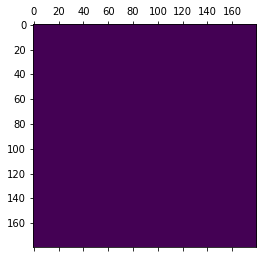

In [ ]:
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning:

divide by zero encountered in true_divide



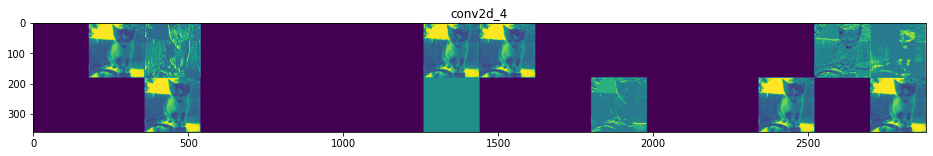

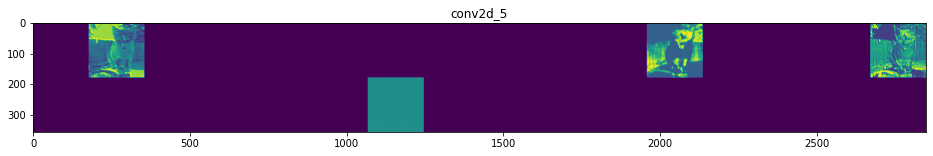

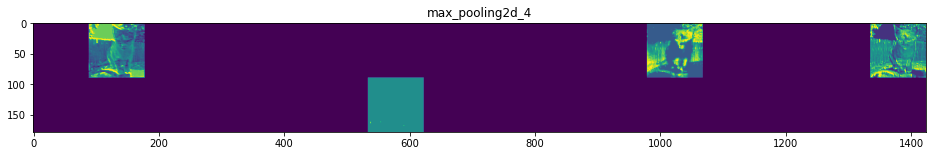

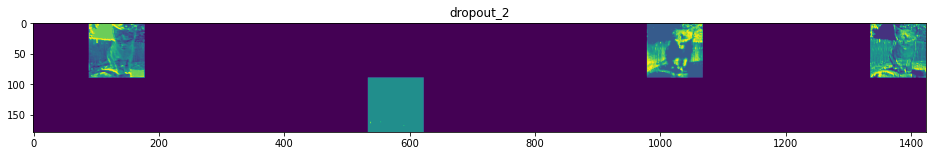

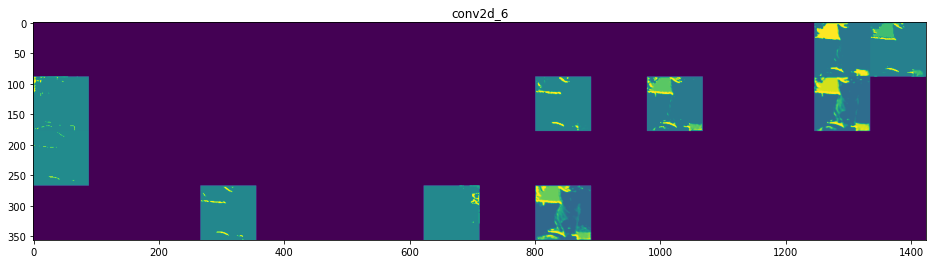

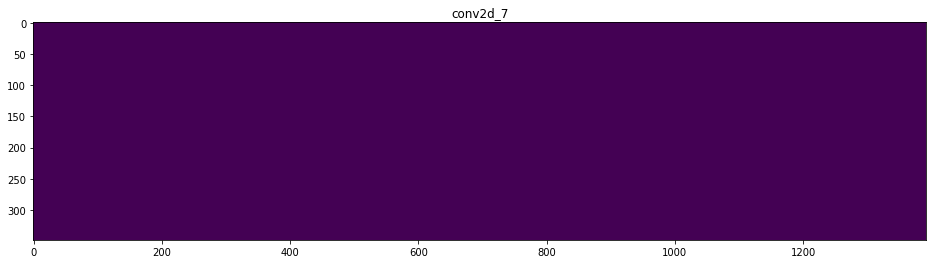

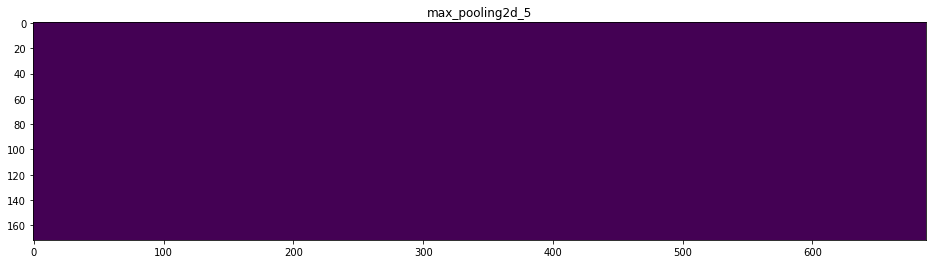

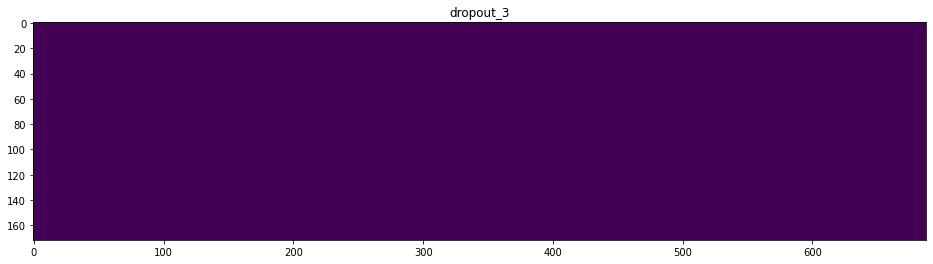

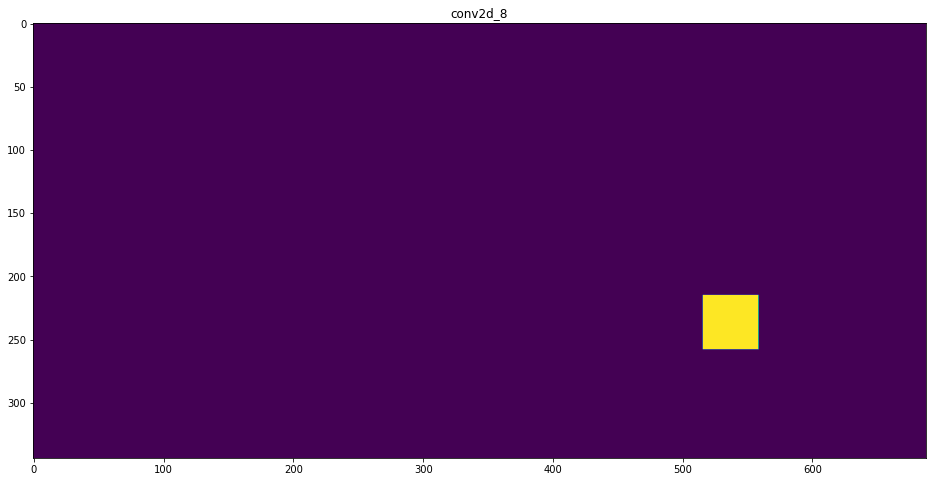

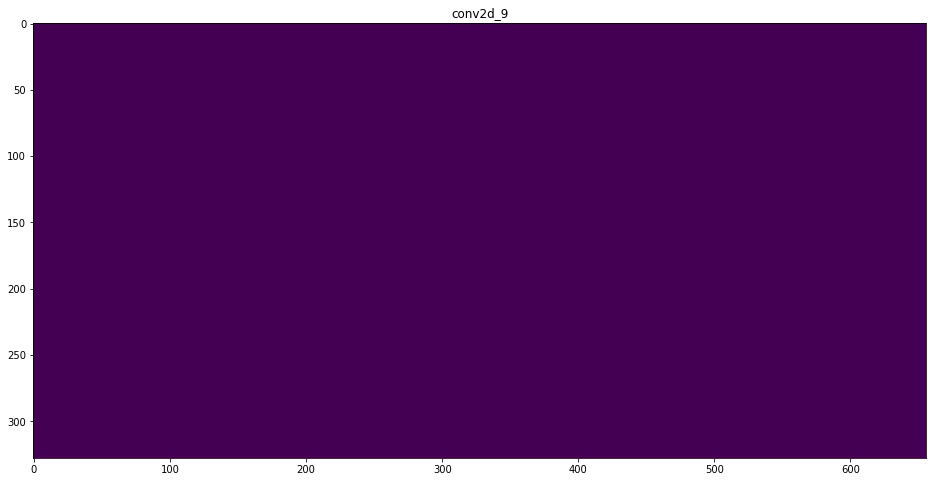

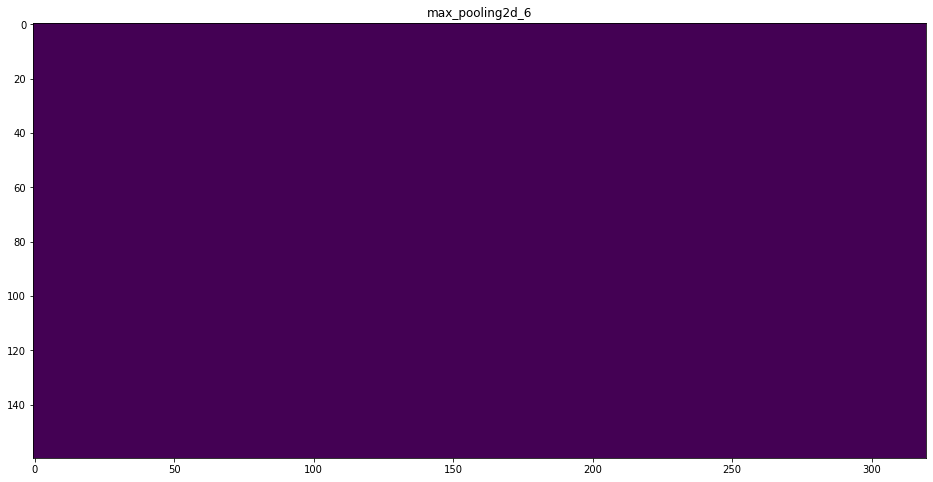

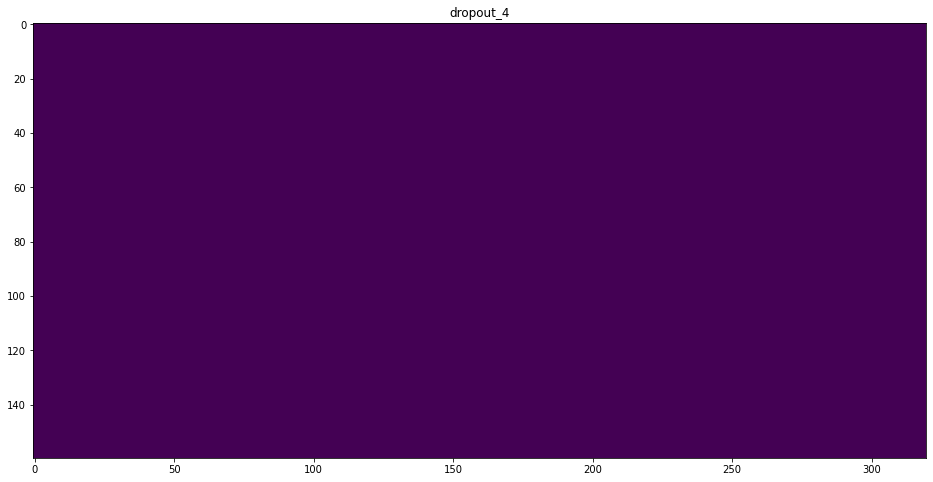

In [ ]:
layer_names = []
for layer in classifier.layers[:12]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

## MODEL 2: VERSION CARMEN 

In [ ]:
input_lyr = keras.layers.Input(shape=(180,180,3))
conv_lyr1 = keras.layers.Conv2D(32, kernel_size=(3,3),
                                 input_shape=(180,180,3),
                                 activation='relu',
                                 padding="same",
                                 data_format="channels_last")(input_lyr)
pool1 = keras.layers.AveragePooling2D(pool_size=(2,2), strides=(2,2))(conv_lyr1)                               
conv_lyr2 = keras.layers.Conv2D(32, kernel_size=(3,3),
                                 activation='relu',
                                 padding="same",
                                 data_format="channels_last")(pool1)
pool2 = keras.layers.AveragePooling2D(pool_size=(2,2), strides=(2,2))(conv_lyr2)
conv_lyr3 = keras.layers.Conv2D(64, kernel_size=(5,5),
                                 activation='relu',
                                 padding="same",
                                 data_format="channels_last")(pool2)
pool3 = keras.layers.AveragePooling2D(pool_size=(2,2), strides=(2,2))(conv_lyr3)   
conv_lyr4 = keras.layers.Conv2D(128, kernel_size=(5,5),
                                 activation='relu',
                                 padding="same",
                                 data_format="channels_last")(pool3)
pool4 = keras.layers.AveragePooling2D(pool_size=(2,2), strides=(2,2))(conv_lyr4)
conv_lyr5 = keras.layers.Conv2D(256, kernel_size=(3,3),
                                 activation='relu',
                                 padding="same",
                                 data_format="channels_last")(pool4)
pool5 = keras.layers.AveragePooling2D(pool_size=(2,2), strides=(2,2))(conv_lyr5)

dropout1 = keras.layers.Dropout(0.5)(pool5)
flat_lyr = keras.layers.Flatten(data_format="channels_last")(dropout1)

dense_lyr1 = keras.layers.Dense(64, activation='relu', kernel_regularizer='l2')(flat_lyr)
dropout2 = keras.layers.Dropout(0.5)(dense_lyr1)
dense_lyr2 = keras.layers.Dense(32, activation='relu')(dropout2)
dropout3 = keras.layers.Dropout(0.5)(dense_lyr2)
dense_lyr3 = keras.layers.Dense(2, activation='softmax')(dropout3)

model_C = keras.Model(inputs=input_lyr, outputs=dense_lyr3)
model_C.compile(optimizer= tf.keras.optimizers.RMSprop(learning_rate=0.00001) , loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model_C.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 conv2d_10 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 average_pooling2d (AverageP  (None, 90, 90, 32)       0         
 ooling2D)                                                       
                                                                 
 conv2d_11 (Conv2D)          (None, 90, 90, 32)        9248      
                                                                 
 average_pooling2d_1 (Averag  (None, 45, 45, 32)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_12 (Conv2D)          (None, 45, 45, 64)        5126

In [ ]:
test = model_C.fit(train_ds, epochs=20, callbacks=callbacks, validation_data=validation_ds)

Epoch 1/20
63/63 [==============================] - 7s 75ms/step - loss: 4.6876 - accuracy: 0.4785 - val_loss: 1.9936 - val_accuracy: 0.5220 - lr: 1.0000e-05
Epoch 2/20
63/63 [==============================] - 5s 70ms/step - loss: 2.7667 - accuracy: 0.5120 - val_loss: 1.9347 - val_accuracy: 0.5180 - lr: 1.0000e-05
Epoch 3/20
63/63 [==============================] - 5s 70ms/step - loss: 2.2477 - accuracy: 0.4835 - val_loss: 1.9044 - val_accuracy: 0.5120 - lr: 1.0000e-05
Epoch 4/20
63/63 [==============================] - 5s 70ms/step - loss: 2.0480 - accuracy: 0.5210 - val_loss: 1.8858 - val_accuracy: 0.5280 - lr: 1.0000e-05
Epoch 5/20
63/63 [==============================] - 5s 71ms/step - loss: 1.9618 - accuracy: 0.5170 - val_loss: 1.8679 - val_accuracy: 0.5080 - lr: 1.0000e-05
Epoch 6/20
63/63 [==============================] - 5s 69ms/step - loss: 1.9153 - accuracy: 0.5045 - val_loss: 1.8492 - val_accuracy: 0.5200 - lr: 1.0000e-05
Epoch 7/20
63/63 [==============================] - 

In [ ]:
model_C.evaluate(test_ds)

16/16 [==============================] - 1s 32ms/step - loss: 1.5482 - accuracy: 0.5280


[1.5481961965560913, 0.527999997138977]

In [ ]:
model_C.evaluate(validation_DA_ds)

16/16 [==============================] - 1s 32ms/step - loss: 1.5481 - accuracy: 0.5300


[1.5480719804763794, 0.5299999713897705]

In [ ]:
#Visualizamos los mapas de características
layer_names = [layer.name for layer in model_C.layers]
layer_outputs = [layer.output for layer in model_C.layers]
feat_map_model = tf.keras.models.Model(inputs=model_C.input, outputs=layer_outputs)

image_path= r"cats_and_dogs_filtered/train/cats/cat.11.jpg"
img = load_img(image_path, target_size=(180, 180))
input = img_to_array(img)                           
input = input.reshape((1,) + input.shape)                   
input /= 255.0

feature_maps = feat_map_model.predict(input)

#Las capas convolucionales tiene dimension == 4
for layer_name, feature_map in zip(layer_names, feature_maps):
  if len(feature_map.shape) == 4:
      k = feature_map.shape[-1]  
      size=feature_map.shape[1]
      for i in range(k):
        feature_image = feature_map[0, :, :, i]
        feature_image-= feature_image.mean()
        feature_image/= feature_image.std ()
        feature_image*=  64
        feature_image+= 128
        feature_image= np.clip(input, 0, 255).astype('uint8')
        #image_belt[:, i * size : (i + 1) * size] = feature_image

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning:

invalid value encountered in true_divide



In [ ]:
layer_outputs = [layer.output for layer in model_C.layers[:12]] # Extracts the outputs of the top 12 layers
activation_model = models.Model(inputs=model_C.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

In [ ]:
activations = activation_model.predict(img_tensor) # Returns a list of five Numpy arrays: one array per layer activation

In [ ]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 180, 180, 3)


0
360
180
180
90


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning:

Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning:

invalid value encountered in true_divide



180
88
176
88
176
80
80


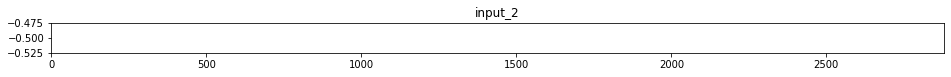

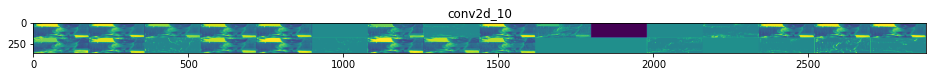

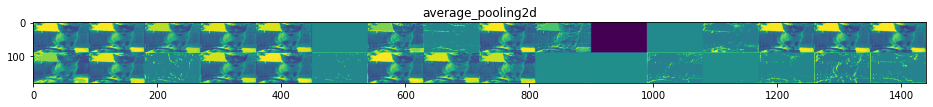

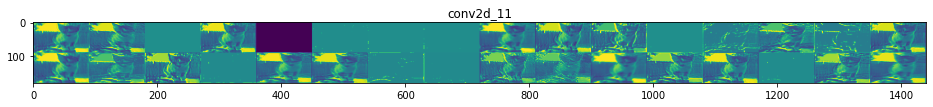

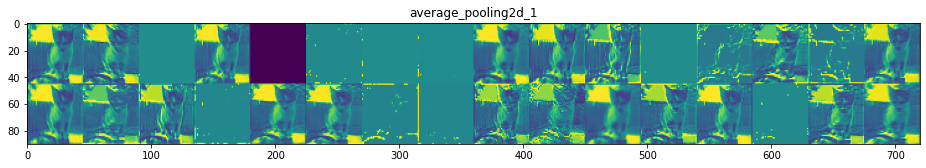

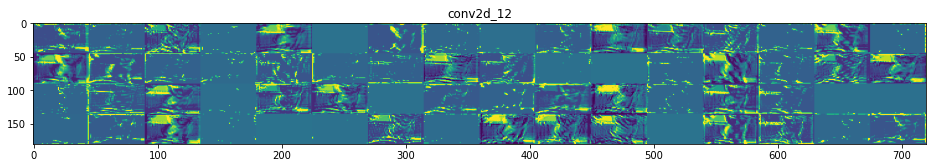

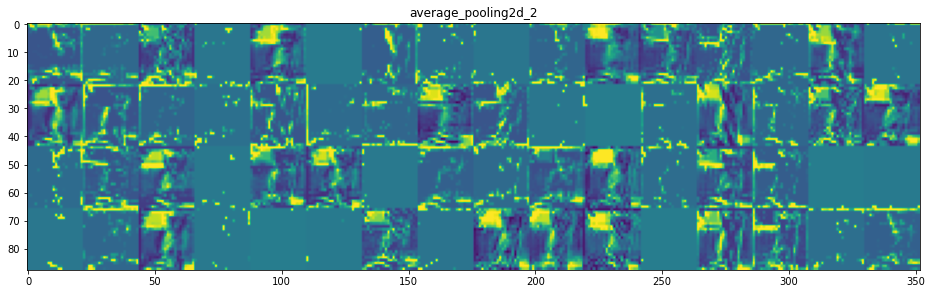

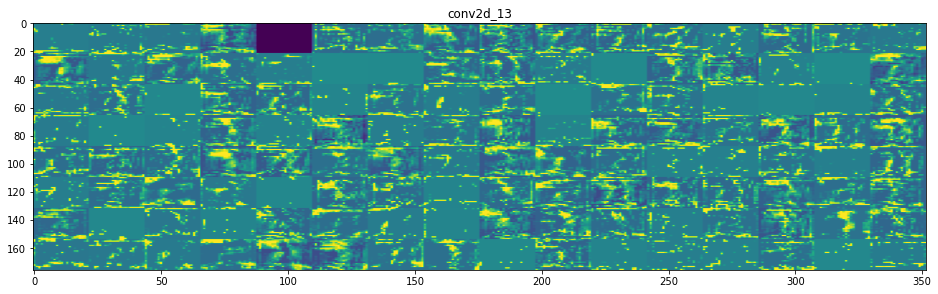

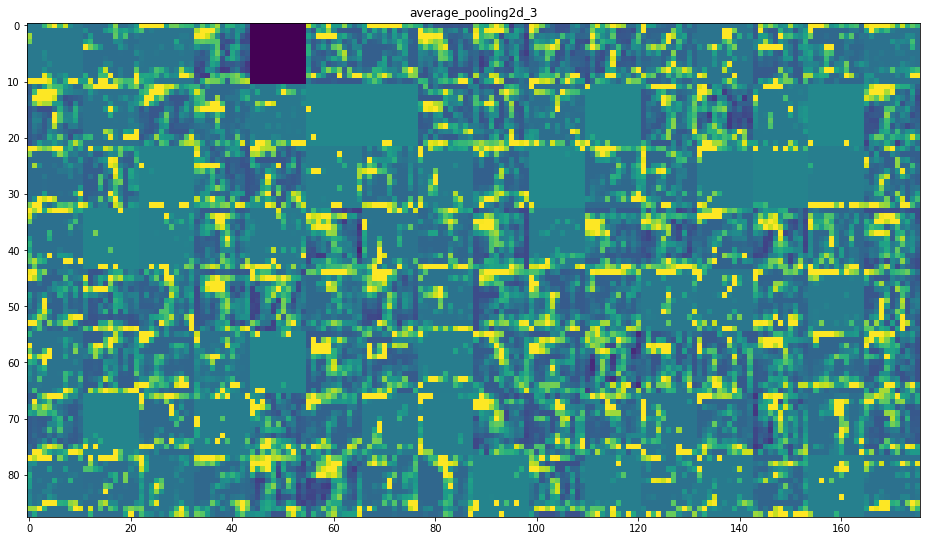

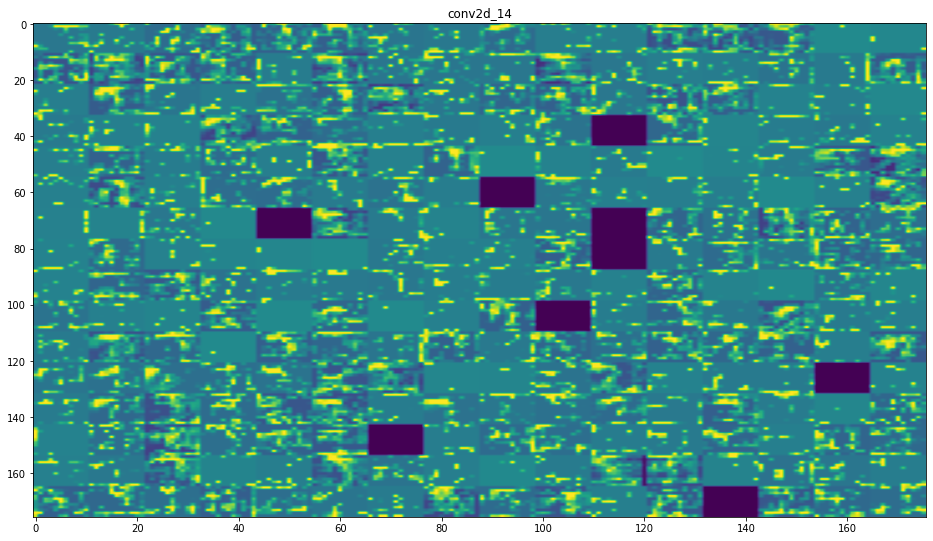

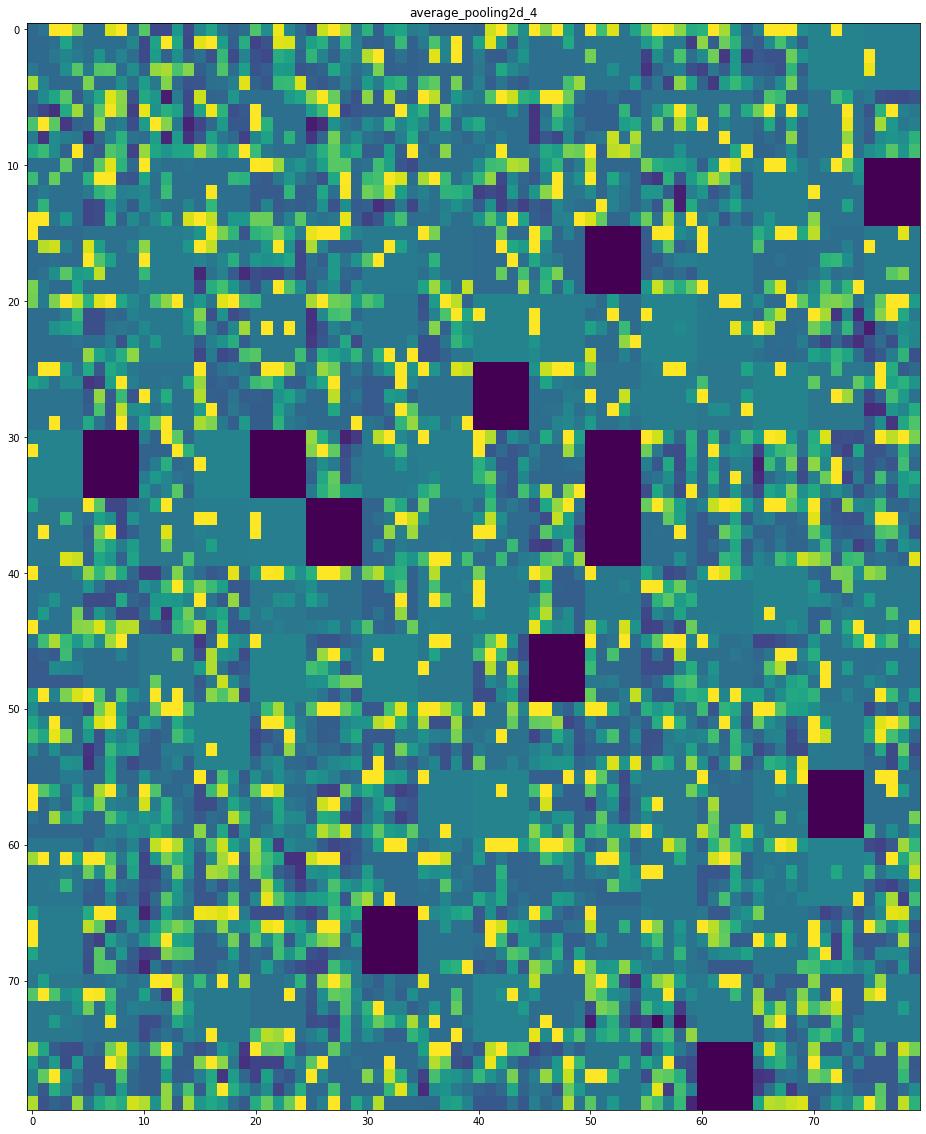

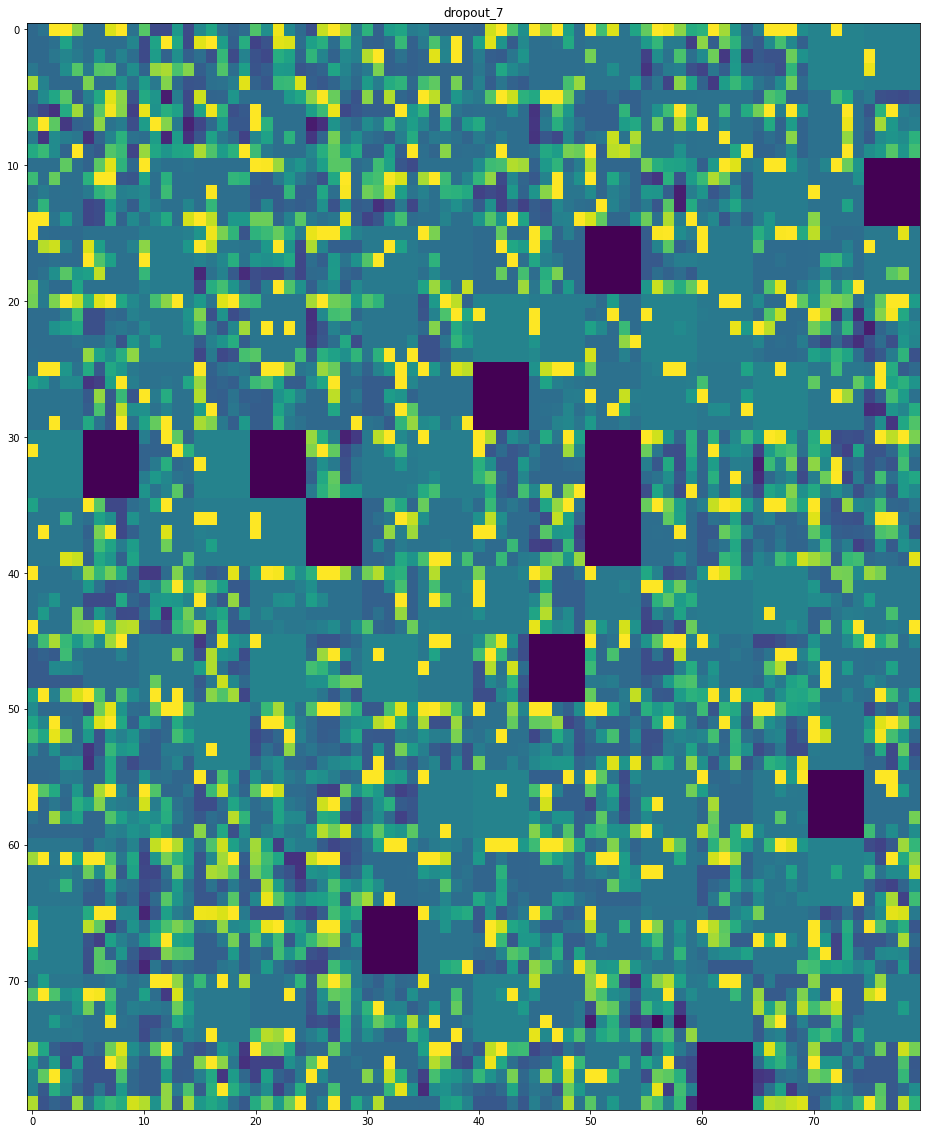

In [ ]:
layer_names = []
for layer in model_C.layers[:12]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    print(display_grid.shape[0])
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * 100))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

NameError: ignored

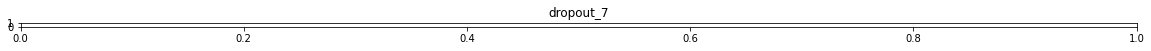

In [ ]:
scale = 20./k
plt.figure(figsize=(scale * k, scale))
plt.title(layer_name)
plt.grid(False)
plt.imshow(image_belt, aspect='auto')

In [ ]:
generate_feature_map(img,3,model)

In [ ]:
generate_feature_map(img,11,model)

# Modelo 3=C

Preparamos las funciones de early stopping y control del learning rate, a aplicar durante el entrenamiento:

In [15]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience=8, verbose=1)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
callbacks_C = [earlystop, learning_rate_reduction]

Definimos el modelo C:

In [16]:
# Modelo C
def mod_C():
  input_layer_C = keras.layers.Input(shape=(180, 180, 3))
  rescaling_C = keras.layers.Rescaling(scale=1./255)(input_layer_C)

  conv_layer_C = keras.layers.Conv2D(32, kernel_size=(3, 3), input_shape=(180, 180, 3), activation='relu')(rescaling_C)
  batch_C = keras.layers.BatchNormalization()(conv_layer_C)                                 
  pooling_C = keras.layers.MaxPooling2D(pool_size=(2,2))(batch_C)

  conv_layer_2_C = keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(pooling_C)
  batch_2_C = keras.layers.BatchNormalization()(conv_layer_2_C)
  pooling_2_C = keras.layers.MaxPooling2D(pool_size=(2,2))(batch_2_C)

  conv_layer_3_C = keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu')(pooling_2_C)
  batch_3_C = keras.layers.BatchNormalization()(conv_layer_3_C)
  pooling_3_C = keras.layers.MaxPooling2D(pool_size=(2,2))(batch_3_C)

  dropout_C = keras.layers.Dropout(0.5)(pooling_3_C)
  flatten_C = keras.layers.Flatten()(dropout_C)
  dense_1_C = keras.layers.Dense(256, activation='relu')(flatten_C) #, kernel_regularizer='l2'?
  dropout_2_C = keras.layers.Dropout(0.5)(dense_1_C)
  output_C = keras.layers.Dense(2, activation='softmax')(dropout_2_C)

  return keras.Model(inputs=input_layer_C, outputs=output_C)

Compilamos y entrenamos el modelo C con data augmentation en el set de validación:

In [17]:
# Modelo C con aumentación de datos
model_C_DA = mod_C()
model_C_DA.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_C_DA.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 178, 178, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496 

In [18]:
history_C_DA = model_C_DA.fit(train_ds, validation_data=validation_DA_ds, epochs=40, callbacks=callbacks_C)

Epoch 1/40
63/63 [==============================] - 18s 125ms/step - loss: 4.4380 - accuracy: 0.5500 - val_loss: 19.5636 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/40
63/63 [==============================] - 7s 112ms/step - loss: 0.8770 - accuracy: 0.5965 - val_loss: 18.0017 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/40
63/63 [==============================] - ETA: 0s - loss: 0.7617 - accuracy: 0.6095
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
63/63 [==============================] - 7s 110ms/step - loss: 0.7617 - accuracy: 0.6095 - val_loss: 8.1765 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/40
63/63 [==============================] - 7s 112ms/step - loss: 0.6016 - accuracy: 0.6710 - val_loss: 3.7790 - val_accuracy: 0.5100 - lr: 5.0000e-04
Epoch 5/40
63/63 [==============================] - 7s 109ms/step - loss: 0.5258 - accuracy: 0.7165 - val_loss: 3.5156 - val_accuracy: 0.5120 - lr: 5.0000e-04
Epoch 6/40
63/63 [==============================] -

Visualizamos la evolución de las métricas y las pérdidas del train y validation:

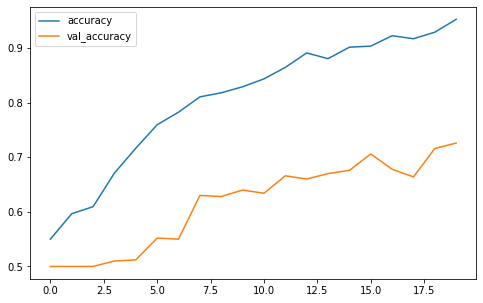

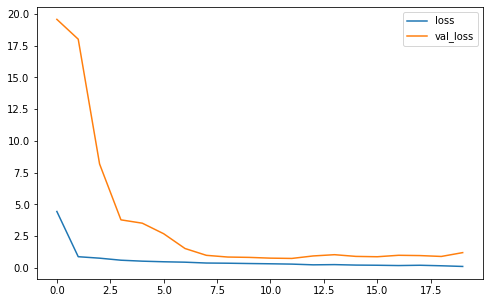

In [19]:
# Curvas modelo CON augmentation
df_C_DA = pd.DataFrame(history_C_DA.history)
df_C_DA_losses = df_C_DA[['loss', 'val_loss']]
df_C_DA_acc = df_C_DA[['accuracy', 'val_accuracy']]
df_C_DA_acc.plot(figsize=(8,5))
df_C_DA_losses.plot(figsize=(8,5))

Repetimos el procedimiento esta vez sin data augmentation en el set de validación:

In [20]:
# Modelo C sin aumentación de datos
model_C = mod_C()
model_C.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_C.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 batch_normalization_3 (Batc  (None, 178, 178, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 87, 87, 64)        1849

In [21]:
history_C = model_C.fit(train_ds, validation_data=validation_ds, epochs=40, callbacks=callbacks_C)

Epoch 1/40
63/63 [==============================] - 8s 115ms/step - loss: 5.3175 - accuracy: 0.5690 - val_loss: 6.2259 - val_accuracy: 0.5020 - lr: 0.0010
Epoch 2/40
63/63 [==============================] - 7s 108ms/step - loss: 0.9543 - accuracy: 0.5800 - val_loss: 11.3495 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/40
63/63 [==============================] - ETA: 0s - loss: 0.7944 - accuracy: 0.6440
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
63/63 [==============================] - 7s 109ms/step - loss: 0.7944 - accuracy: 0.6440 - val_loss: 19.2219 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/40
63/63 [==============================] - 7s 110ms/step - loss: 0.5720 - accuracy: 0.7060 - val_loss: 13.5827 - val_accuracy: 0.5000 - lr: 5.0000e-04
Epoch 5/40
63/63 [==============================] - 7s 109ms/step - loss: 0.5385 - accuracy: 0.7320 - val_loss: 2.4505 - val_accuracy: 0.5100 - lr: 5.0000e-04
Epoch 6/40
63/63 [==============================] -

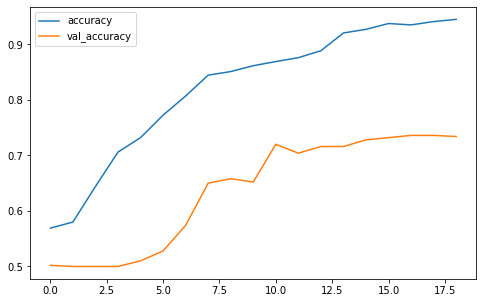

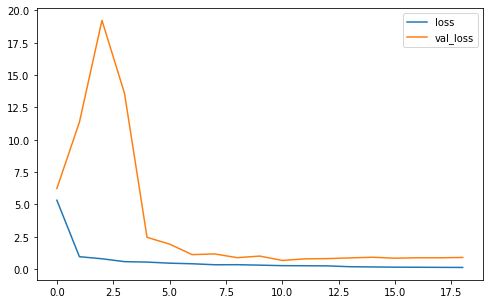

In [22]:
# Curvas modelo SIN augmentation
df_C = pd.DataFrame(history_C.history)
df_C_losses = df_C[['loss', 'val_loss']]
df_C_acc = df_C[['accuracy', 'val_accuracy']]
df_C_acc.plot(figsize=(8,5))
df_C_losses.plot(figsize=(8,5))

Evaluación de los dos modelos C.

In [23]:
# SIN DA
scores_C = model_C.evaluate(test_ds, callbacks=callbacks_C)

16/16 [==============================] - 1s 46ms/step - loss: 0.8878 - accuracy: 0.7300


In [24]:
# CON DA
scores_C_DA = model_C_DA.evaluate(test_ds, callbacks=callbacks_C)

16/16 [==============================] - 1s 48ms/step - loss: 1.1087 - accuracy: 0.7000


Tras múltiples entrenamientos obtenemos indistintamente mejores resultados con o sin data augmentation. Visualizamos los mapas de características de primeras y últimas capas del modelo con aumentación:

In [27]:
model_C_DA.layers

Mapa de características directamete a la salida de la primera capa convolucional.

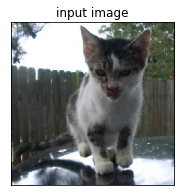

Salidas capa conv2d (1, 178, 178, 32)


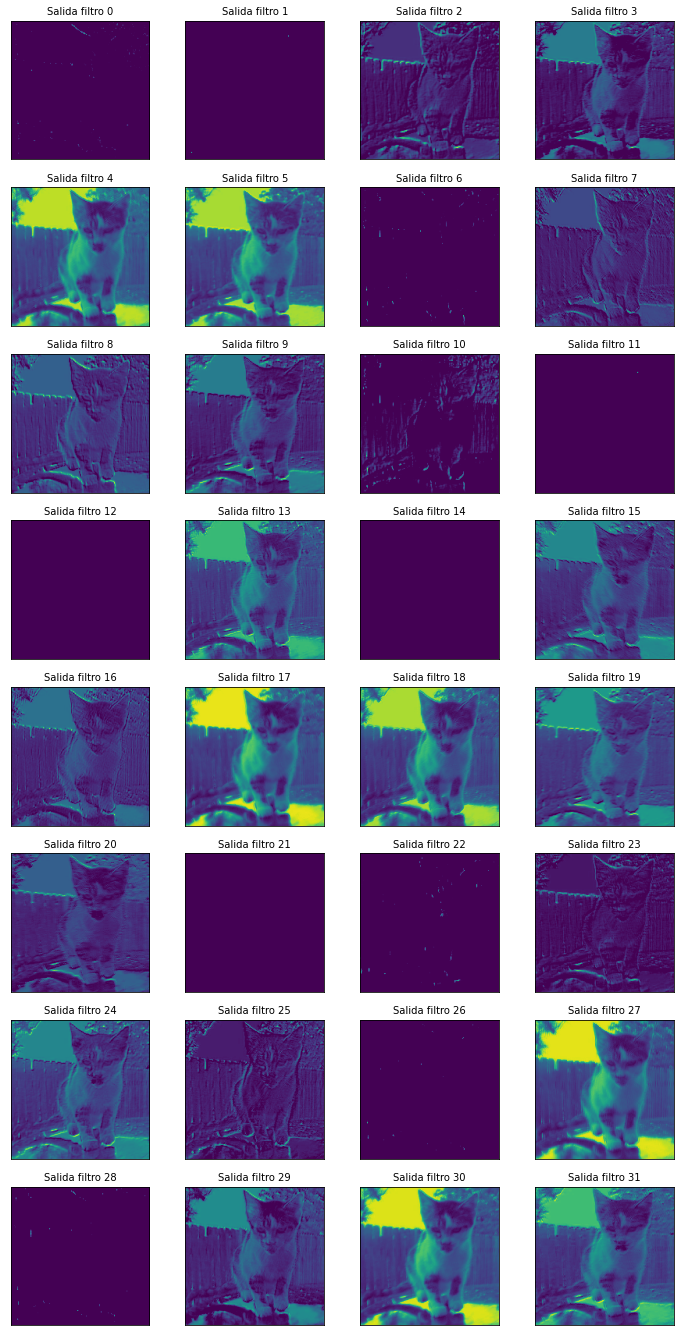

In [35]:
generate_feature_map(img,2,model_C_DA)

Mapa de características después del batch normalization y max pooling de la tercera y última capa convolucional:

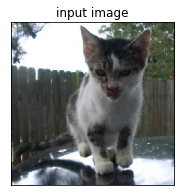

Salidas capa dropout (1, 20, 20, 128)


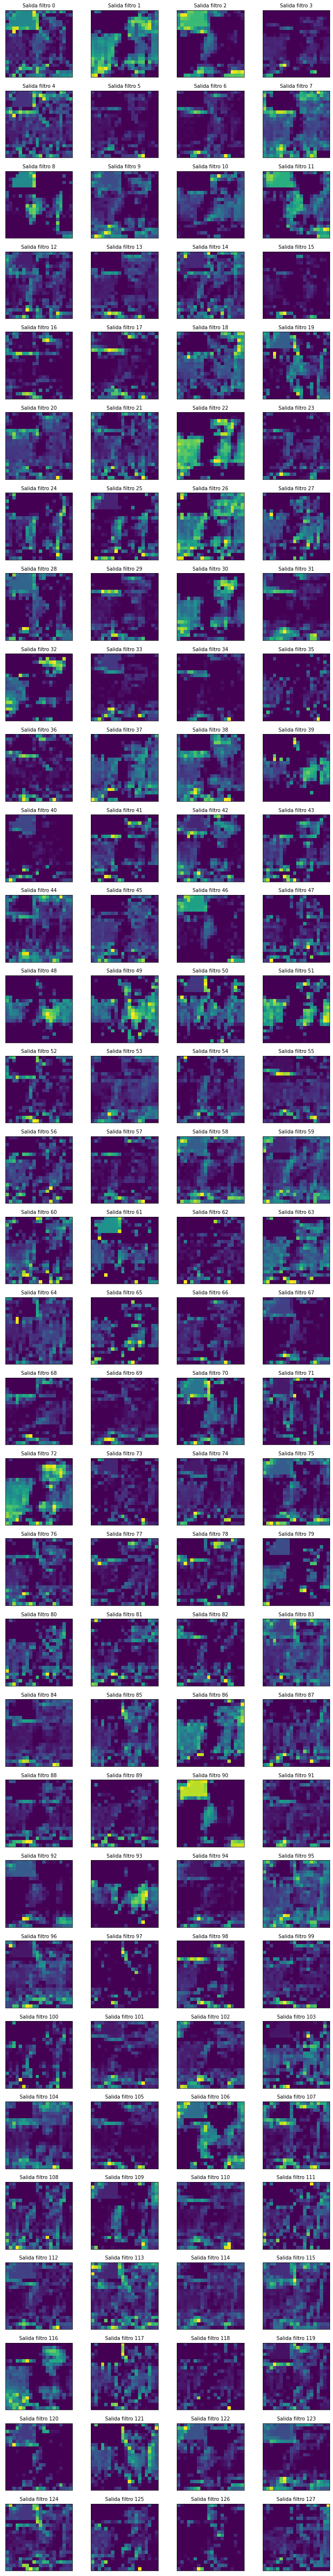

In [33]:
generate_feature_map(img,11,model_C_DA)